In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import randint

from mpl_toolkits.mplot3d import Axes3D
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import RandomizedSearchCV, train_test_split, cross_val_predict

In [2]:
# Load
df = pd.read_csv('./csv/rgb/2020/jan/result_pixel_lama.csv')
df

,Brightness,Greenness,Wetness,Label
0,842.2758,-813.0349,296.9032,0
1,843.3638,-818.6690,305.2600,0
2,844.1852,-814.8974,306.8829,0
3,842.6391,-818.0620,311.2136,0
4,853.5087,-809.4131,297.8298,0
...,...,...,...,...
217621,532.3411,-469.5781,69.6142,4
217622,535.2914,-470.2087,70.2396,4
217623,525.1675,-474.7531,76.0929,4
217624,525.6399,-477.4644,55.7703,4


In [3]:
df.head()

,Brightness,Greenness,Wetness,Label
0,842.2758,-813.0349,296.9032,0
1,843.3638,-818.6690,305.2600,0
2,844.1852,-814.8974,306.8829,0
3,842.6391,-818.0620,311.2136,0
4,853.5087,-809.4131,297.8298,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217626 entries, 0 to 217625
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Brightness  217626 non-null  float64
 1   Greenness   217626 non-null  float64
 2   Wetness     217626 non-null  float64
 3   Label       217626 non-null  int64  
dtypes: float64(3), int64(1)
memory usage: 6.6 MB


In [5]:
df.describe()

,Brightness,Greenness,Wetness,Label
count,217626.000000,217626.000000,217626.000000,217626.000000
mean,2146.760631,-264.869231,-1578.996321,2.061624
std,1289.900940,295.955791,577.806213,0.833372
min,331.688900,-4708.738300,-11135.087000,0.000000
25%,1628.154250,-361.931125,-1746.483450,2.000000
50%,1797.466800,-284.037400,-1531.975500,2.000000
75%,2067.637175,-215.522825,-1373.627300,2.000000
max,22401.303000,1236.921300,364.448100,4.000000


In [6]:
df['Label'].value_counts()

Label
2    143327
3     40394
0     17687
4      8203
1      8015
Name: count, dtype: int64

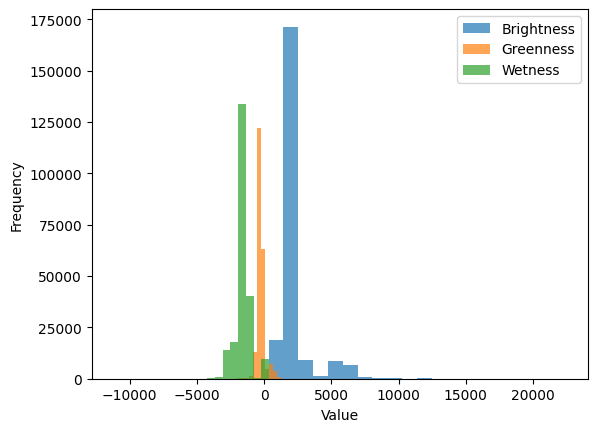

In [7]:

plt.hist(df['Brightness'], bins=20, alpha=0.7, label='Brightness')
plt.hist(df['Greenness'], bins=20, alpha=0.7, label='Greenness')
plt.hist(df['Wetness'], bins=20, alpha=0.7, label='Wetness')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

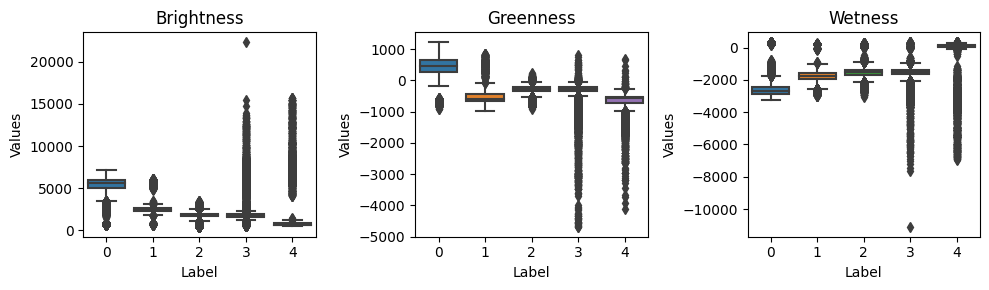

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 3))

sns.boxplot(x='Label', y='Brightness', data=df, ax=axes[0])
axes[0].set_title('Brightness')
axes[0].set_ylabel('Values')

sns.boxplot(x='Label', y='Greenness', data=df, ax=axes[1])
axes[1].set_title('Greenness')
axes[1].set_ylabel('Values')

sns.boxplot(x='Label', y='Wetness', data=df, ax=axes[2])
axes[2].set_title('Wetness')
axes[2].set_ylabel('Values')

# Adjust layout and display plots
plt.tight_layout()
plt.show()

# Data Preprocessing

### Outlier Dectection

#### Z-Score

In [31]:
from scipy.stats import zscore
z_scores = zscore(df['Wetness'])
z_threshold = 2.5
z_outliers = np.where(np.abs(z_scores) > z_threshold)[0]
print("Z-Score outliers:", z_outliers)


Z-Score outliers: [     0      1      2 ... 217623 217624 217625]
(11744,)


#### IQR Method

In [34]:
from scipy.stats import iqr
q1 = np.percentile(df["Label"], 25)
q3 = np.percentile(df["Label"], 75)
iqr_value = q3 - q1
iqr_threshold = 1.5
iqr_outliers = np.where((df["Label"] < q1 - iqr_threshold * iqr_value) | (df["Label"] > q3 + iqr_threshold * iqr_value))[0]
print("IQR outliers:", iqr_outliers)
print(iqr_outliers.shape)

IQR outliers: [     0      1      2 ... 217623 217624 217625]
(74299,)


### Truncate

In [9]:
# Remove outlier
def remove_outliers(df, column_name, threshold):
    q1 = df[column_name].quantile(0.25)
    q3 = df[column_name].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - (threshold * iqr)
    upper_bound = q3 + (threshold * iqr)
    df_filtered = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]
    return df_filtered

In [10]:
truncate = remove_outliers(df, "Greenness", 1.5)
# no_outlier_df = remove_outliers(no_outlier_df, "Wetness", 1.5)
# no_outlier_df = remove_outliers(no_outlier_df, "Brightness", 1)
truncate.info()

<class 'pandas.core.frame.DataFrame'>
Index: 187551 entries, 5166 to 217625
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Brightness  187551 non-null  float64
 1   Greenness   187551 non-null  float64
 2   Wetness     187551 non-null  float64
 3   Label       187551 non-null  int64  
dtypes: float64(3), int64(1)
memory usage: 7.2 MB


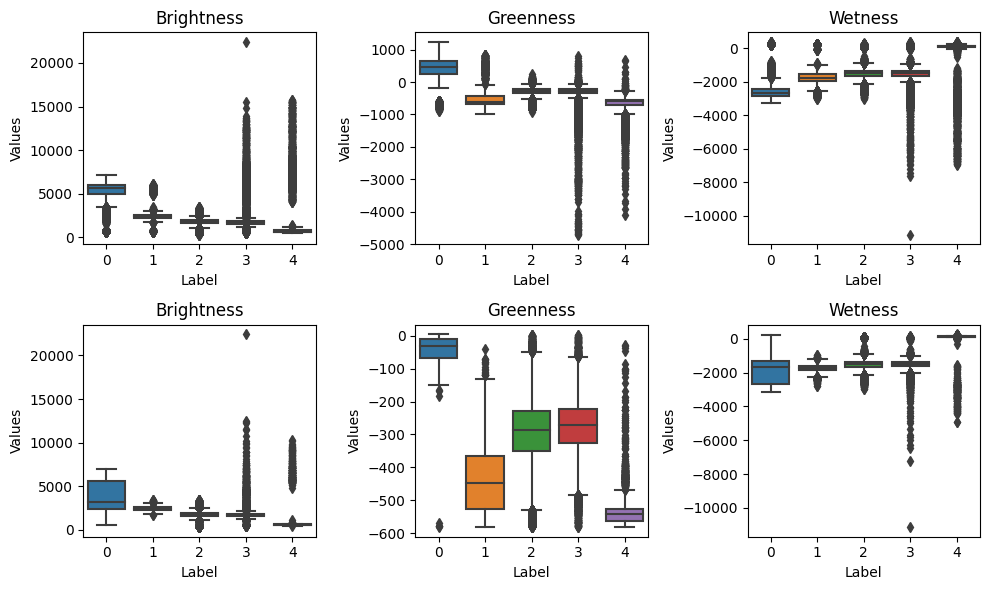

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

sns.boxplot(x='Label', y='Brightness', data=df, ax=axes[0, 0])
axes[0, 0].set_title('Brightness')
axes[0, 0].set_ylabel('Values')

sns.boxplot(x='Label', y='Greenness', data=df, ax=axes[0, 1])
axes[0, 1].set_title('Greenness')
axes[0, 1].set_ylabel('Values')

sns.boxplot(x='Label', y='Wetness', data=df, ax=axes[0, 2])
axes[0, 2].set_title('Wetness')
axes[0, 2].set_ylabel('Values')

sns.boxplot(x='Label', y='Brightness', data=truncate, ax=axes[1, 0])
axes[1, 0].set_title('Brightness')
axes[1, 0].set_ylabel('Values')

sns.boxplot(x='Label', y='Greenness', data=truncate, ax=axes[1, 1])
axes[1, 1].set_title('Greenness')
axes[1, 1].set_ylabel('Values')

sns.boxplot(x='Label', y='Wetness', data=truncate, ax=axes[1, 2])
axes[1, 2].set_title('Wetness')
axes[1, 2].set_ylabel('Values')

# Adjust layout and display plots
plt.tight_layout()
plt.show()

In [12]:
truncate['Label'].value_counts()

Label
2    141477
3     38758
4      4141
1      2931
0       244
Name: count, dtype: int64

### Windsorizing

In [9]:
lower_percentile = 5
upper_percentile = 95

windsoring = df.copy()

# Loop through the columns you want to Windsorize
for column in ['Brightness', 'Greenness', 'Wetness']:
    # Calculate the lower and upper bounds for Windsorizing
    lower_bound = windsoring[column].quantile(lower_percentile / 100)
    upper_bound = windsoring[column].quantile(upper_percentile / 100)
    
    # Apply Windsorizing to the column
    windsoring[column] = windsoring[column].apply(lambda x: lower_bound if x < lower_bound else upper_bound if x > upper_bound else x)

# Print the DataFrame after Windsorizing
print(windsoring)

         Brightness   Greenness     Wetness  Label
0       1224.179625 -613.616775 -999.967875      0
1       1224.179625 -613.616775 -999.967875      0
2       1224.179625 -613.616775 -999.967875      0
3       1224.179625 -613.616775 -999.967875      0
4       1224.179625 -613.616775 -999.967875      0
...             ...         ...         ...    ...
217621  1224.179625 -469.578100 -999.967875      4
217622  1224.179625 -470.208700 -999.967875      4
217623  1224.179625 -474.753100 -999.967875      4
217624  1224.179625 -477.464400 -999.967875      4
217625  1224.179625 -455.427100 -999.967875      4

[217626 rows x 4 columns]


In [10]:
windsoring['Label'].value_counts()

Label
2    143327
3     40394
0     17687
4      8203
1      8015
Name: count, dtype: int64

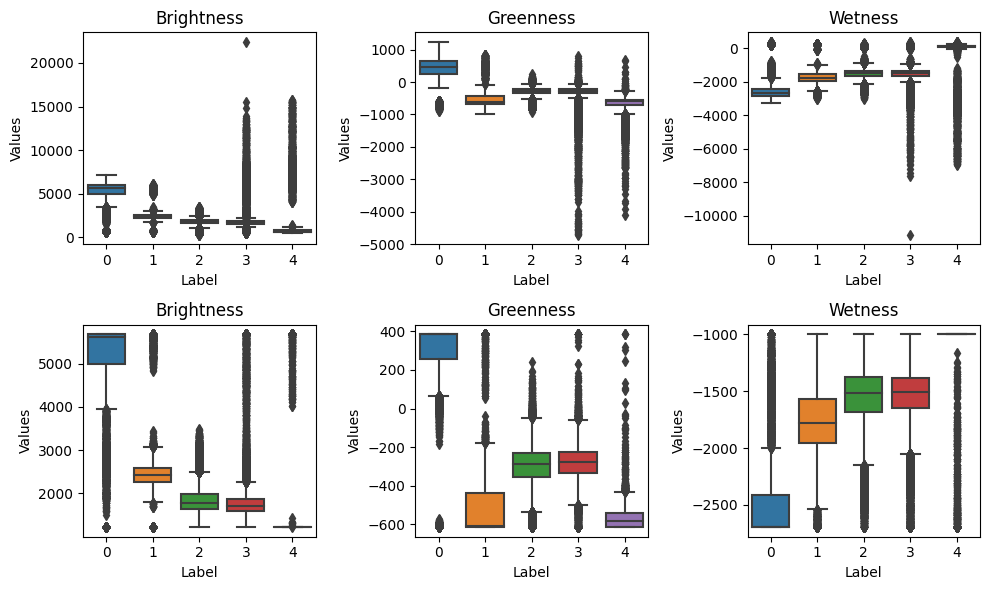

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

sns.boxplot(x='Label', y='Brightness', data=df, ax=axes[0, 0])
axes[0, 0].set_title('Brightness')
axes[0, 0].set_ylabel('Values')

sns.boxplot(x='Label', y='Greenness', data=df, ax=axes[0, 1])
axes[0, 1].set_title('Greenness')
axes[0, 1].set_ylabel('Values')

sns.boxplot(x='Label', y='Wetness', data=df, ax=axes[0, 2])
axes[0, 2].set_title('Wetness')
axes[0, 2].set_ylabel('Values')

sns.boxplot(x='Label', y='Brightness', data=windsoring, ax=axes[1, 0])
axes[1, 0].set_title('Brightness')
axes[1, 0].set_ylabel('Values')

sns.boxplot(x='Label', y='Greenness', data=windsoring, ax=axes[1, 1])
axes[1, 1].set_title('Greenness')
axes[1, 1].set_ylabel('Values')

sns.boxplot(x='Label', y='Wetness', data=windsoring, ax=axes[1, 2])
axes[1, 2].set_title('Wetness')
axes[1, 2].set_ylabel('Values')

# Adjust layout and display plots
plt.tight_layout()
plt.show()

### Scaling Data

In [13]:
# min max scaller
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
mm_df = windsoring.copy()
numerical_columns = ['Brightness', 'Greenness', 'Wetness']
mm_df[numerical_columns] = scaler.fit_transform(mm_df[numerical_columns])
print("Original\n", df.head())
print("\nMin Max \n", mm_df.head())

Original
    Brightness  Greenness   Wetness  Label
0    842.2758  -813.0349  296.9032      0
1    843.3638  -818.6690  305.2600      0
2    844.1852  -814.8974  306.8829      0
3    842.6391  -818.0620  311.2136      0
4    853.5087  -809.4131  297.8298      0

Min Max 
    Brightness  Greenness  Wetness  Label
0         0.0        0.0      1.0      0
1         0.0        0.0      1.0      0
2         0.0        0.0      1.0      0
3         0.0        0.0      1.0      0
4         0.0        0.0      1.0      0


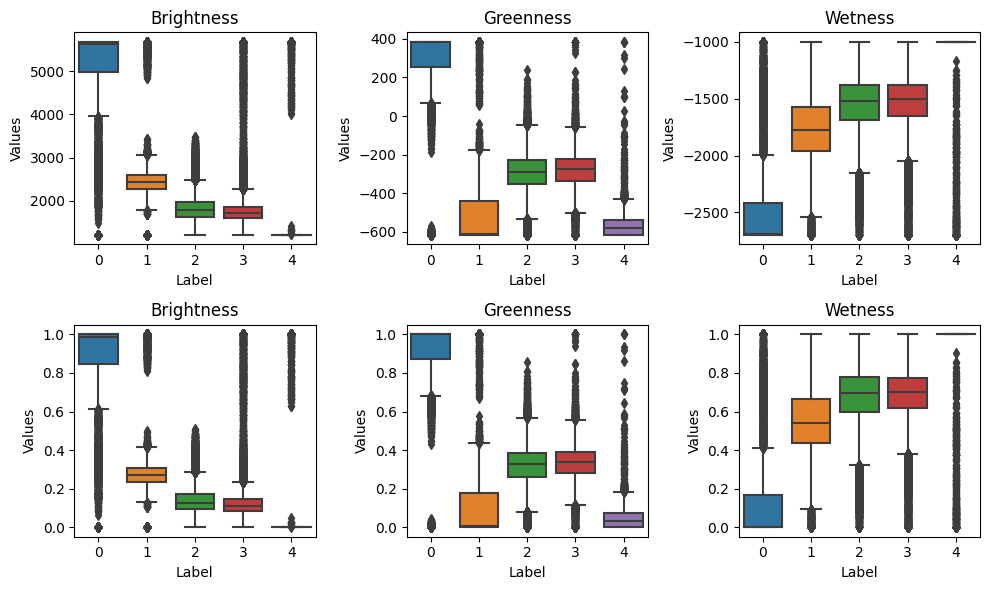

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

sns.boxplot(x='Label', y='Brightness', data=windsoring, ax=axes[0, 0])
axes[0, 0].set_title('Brightness')
axes[0, 0].set_ylabel('Values')

sns.boxplot(x='Label', y='Greenness', data=windsoring, ax=axes[0, 1])
axes[0, 1].set_title('Greenness')
axes[0, 1].set_ylabel('Values')

sns.boxplot(x='Label', y='Wetness', data=windsoring, ax=axes[0, 2])
axes[0, 2].set_title('Wetness')
axes[0, 2].set_ylabel('Values')

sns.boxplot(x='Label', y='Brightness', data=mm_df, ax=axes[1, 0])
axes[1, 0].set_title('Brightness')
axes[1, 0].set_ylabel('Values')

sns.boxplot(x='Label', y='Greenness', data=mm_df, ax=axes[1, 1])
axes[1, 1].set_title('Greenness')
axes[1, 1].set_ylabel('Values')

sns.boxplot(x='Label', y='Wetness', data=mm_df, ax=axes[1, 2])
axes[1, 2].set_title('Wetness')
axes[1, 2].set_ylabel('Values')

# Adjust layout and display plots
plt.tight_layout()
plt.show()

### Under Sample

In [15]:
# Separate features and labels
X = mm_df[['Brightness', 'Greenness', 'Wetness']]
y = mm_df['Label']

# Create the RandomUnderSampler object
under_sampler = RandomUnderSampler(random_state=42)

# Perform undersampling on the majority class
X_resample, y_resample = under_sampler.fit_resample(X, y)

undersampled_df = pd.DataFrame(data={
    'Brightness': X_resample['Brightness'],
    'Greenness': X_resample['Greenness'], 
    'Wetness': X_resample['Wetness'], 
    'Label': y_resample,
})

In [16]:
print(mm_df['Label'].value_counts())
print(undersampled_df['Label'].value_counts())

Label
2    143327
3     40394
0     17687
4      8203
1      8015
Name: count, dtype: int64
Label
0    8015
1    8015
2    8015
3    8015
4    8015
Name: count, dtype: int64


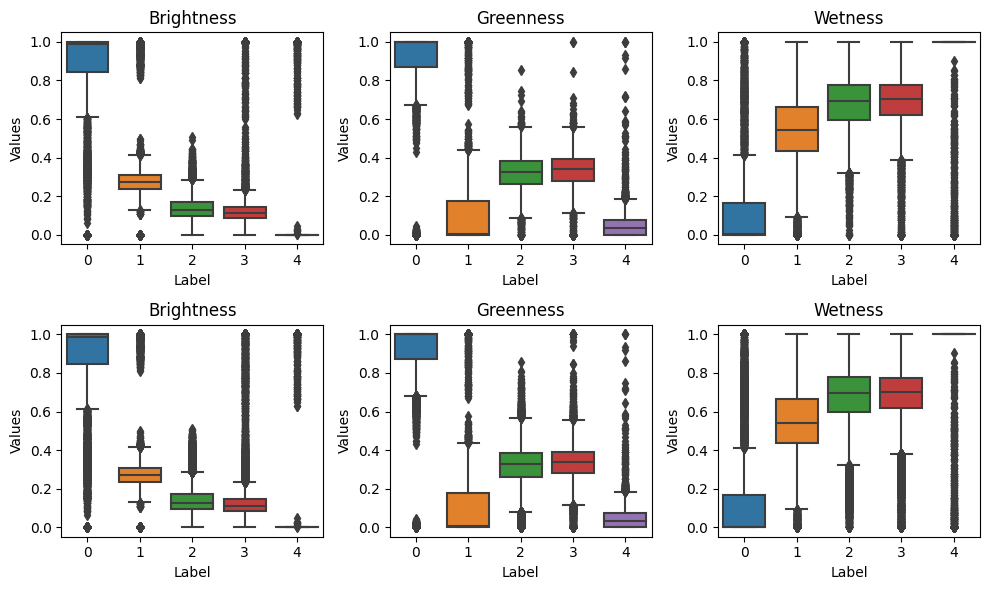

In [17]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

sns.boxplot(x='Label', y='Brightness', data=undersampled_df, ax=axes[0, 0])
axes[0, 0].set_title('Brightness')
axes[0, 0].set_ylabel('Values')

sns.boxplot(x='Label', y='Greenness', data=undersampled_df, ax=axes[0, 1])
axes[0, 1].set_title('Greenness')
axes[0, 1].set_ylabel('Values')

sns.boxplot(x='Label', y='Wetness', data=undersampled_df, ax=axes[0, 2])
axes[0, 2].set_title('Wetness')
axes[0, 2].set_ylabel('Values')

sns.boxplot(x='Label', y='Brightness', data=mm_df, ax=axes[1, 0])
axes[1, 0].set_title('Brightness')
axes[1, 0].set_ylabel('Values')

sns.boxplot(x='Label', y='Greenness', data=mm_df, ax=axes[1, 1])
axes[1, 1].set_title('Greenness')
axes[1, 1].set_ylabel('Values')

sns.boxplot(x='Label', y='Wetness', data=mm_df, ax=axes[1, 2])
axes[1, 2].set_title('Wetness')
axes[1, 2].set_ylabel('Values')

# Adjust layout and display plots
plt.tight_layout()
plt.show()

### Train and Test Split

In [18]:
X = undersampled_df[['Brightness', 'Greenness', 'Wetness']]
y = undersampled_df['Label']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit To Model

In [20]:
best_model = RandomForestClassifier()

best_model.fit(X_train, y_train)

RandomForestClassifier()

In [21]:
predicted_labels = cross_val_predict(best_model, X, y, cv=10)

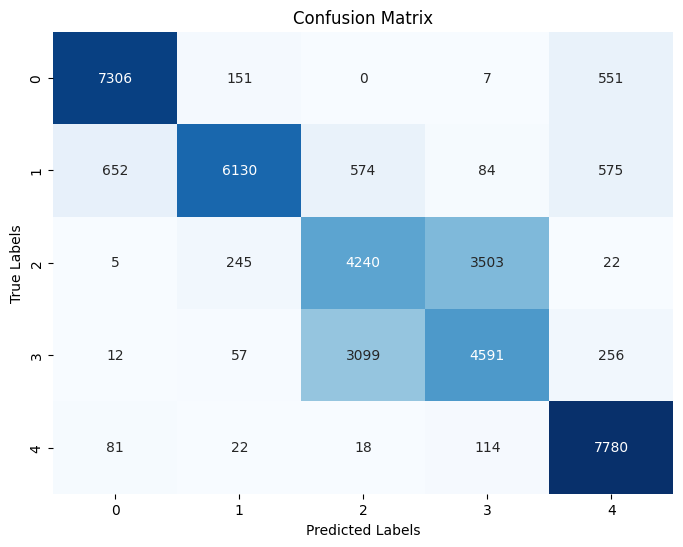

In [22]:
cm = confusion_matrix(y, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [23]:
report = classification_report(y, predicted_labels)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      8015
           1       0.93      0.76      0.84      8015
           2       0.53      0.53      0.53      8015
           3       0.55      0.57      0.56      8015
           4       0.85      0.97      0.90      8015

    accuracy                           0.75     40075
   macro avg       0.75      0.75      0.75     40075
weighted avg       0.75      0.75      0.75     40075



In [24]:
from sklearn.metrics import cohen_kappa_score
kappa = cohen_kappa_score(y, predicted_labels)
print("Kappa Cohen :", kappa)

Kappa Cohen : 0.687211478477854


# Save Model

In [25]:
import joblib
model_output_file = './model/model7'
joblib.dump(best_model, f'{model_output_file}.joblib')

['./model/model7.joblib']